In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.sim_manager import CachedHaloCatalog
from halotools import sim_manager
from halotools.mock_observables import return_xyz_formatted_array
# from halotools.mock_observables import wp
import halotools.sim_manager.sim_defaults as sim_defaults
from halotools.mock_observables import mock_survey
# from halotools.mock_observables import angular_tpcf

sim_defaults.default_simname = 'multidark'
sim_defaults.default_redshift = 0.5 # multidark actual z = 0.466

import Corrfunc

In [2]:
# set plot defaults
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'medium'

In [ ]:
# Download halo catalogs (only needs to be done once)
# from halotools.sim_manager import DownloadManager
# dman = DownloadManager()
# dman.download_processed_halo_table('multidark', 'rockstar', 0.5) 

# Get halo and mock data

In [3]:
# get Multidark + ROCKSTAR halo catalog

halocat = CachedHaloCatalog(simname = 'multidark', halo_finder = 'rockstar', \
                            version_name = 'halotools_v0p4', redshift = 0.5)

In [4]:
# zheng07 HOD model
# https://halotools.readthedocs.io/en/latest/quickstart_and_tutorials/tutorials/model_building/preloaded_models/zheng07_composite_model.html

HODmodel = PrebuiltHodModelFactory('zheng07', threshold = -21, redshift = 0.5)

# values from Rongpu's LRG analysis (see Slack message)
HODmodel.param_dict['logMmin'] = 12.89376701 # Minimum mass required for a halo to host a central galaxy.
HODmodel.param_dict['sigma_logM'] = 0.23939566 # Rate of transition from ⟨Ncen⟩=0⇒⟨Ncen=1⟩
HODmodel.param_dict['logM0'] = 12.26827089 # Low-mass cutoff in ⟨Nsat⟩
HODmodel.param_dict['logM1'] = 14.03372441 # Characteristic halo mass where ⟨Nsat⟩ begins to assume a power law form.
HODmodel.param_dict['alpha'] = 1.32828278 # Power law slope of the relation between halo mass and ⟨Nsat⟩.
HODmodel.param_dict

{'logMmin': 12.89376701,
 'sigma_logM': 0.23939566,
 'logM0': 12.26827089,
 'logM1': 14.03372441,
 'alpha': 1.32828278}

In [5]:
# Create mock galaxy catalogs
# (only last instance is available for future calls on HODmodel.mock)

HODmodel.populate_mock(halocat) # use this command to create and populate the mock
gals2 = HODmodel.mock.galaxy_table # save the galaxy_table for future use

# if i repopulate do i get different results?
# yes, but many coords are exactly the same which is weird?
HODmodel.mock.populate() # use this command to REpopulate
gals = HODmodel.mock.galaxy_table
# gals[3] # sample
# gals.info

/home/tjr63/miniconda3/envs/halotools_env/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/home/tjr63/miniconda3/envs/halotools_env/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/home/tjr63/miniconda3

In [ ]:
coords = np.vstack([gals['x'], gals['y'], gals['z']]).T
type(coords)

In [ ]:
# from mpl_toolkits import mplot3d

In [ ]:
# look at galaxy distribution
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(np.asarray(gals['x']), np.asarray(gals['y']), np.asarray(gals['z']), \
            s=0.0001)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.zlabel('z')
# plt.show()

# Correlation functions from Corrfunc

In [ ]:
boxsize = halocat.Lbox[0]
nthreads = 48
bins = np.linspace(50,125, 50)

In [ ]:
def get_gal_xyz(galaxy_table):
    x = np.array(galaxy_table['x'])
    y = np.array(galaxy_table['y'])
    z = np.array(galaxy_table['z'])
    return [x, y, z]

In [ ]:
# xi
xi_field_list = ['rmin', 'rmax', 'ravg', 'xi', 'npairs', 'weightavg']

x, y, z = get_gal_xyz(gals)
xiresults = Corrfunc.theory.xi(boxsize, nthreads, bins, x, y, z)
rcen = (xiresults['rmin'] + xiresults['rmax']) / 2.
xivals = xiresults['xi']

x2, y2, z2 = get_gal_xyz(gals2)
xiresults2 = Corrfunc.theory.xi(boxsize, nthreads, bins, x2, y2, z2)
rcen2 = (xiresults2['rmin'] + xiresults2['rmax']) / 2.
xivals2 = xiresults2['xi']

In [ ]:
# xi
plt.figure()
plt.plot(rcen, xivals, label='gals')
plt.plot(rcen2, xivals2, label='gals2')
plt.xlabel(r'$r_{center}$')
plt.ylabel(r'$\xi$')
plt.legend()
plt.title(r'$\xi (r)$')
plt.tight_layout()
plt.show()

In [ ]:
# wp
wp_field_list = ['rmin', 'rmax', 'rpavg', 'wp', 'npairs', 'weightavg']

pi_max_list = [50, 125, 300]

wpresults = {}
x, y, z = get_gal_xyz(gals)
for pi_max in pi_max_list:
    wpresults[pi_max] = Corrfunc.theory.wp(boxsize, pi_max, nthreads, bins, x, y, z)

wpresults2 = {}
x2, y2, z2 = get_gal_xyz(gals2)
for pi_max in pi_max_list:
    wpresults2[pi_max] = Corrfunc.theory.wp(boxsize, pi_max, nthreads, bins, x2, y2, z2)

In [ ]:
def get_wp_plot_data(wp_results):
    rcen = np.array((wp_results['rmin'] + wp_results['rmax']) / 2.)
    wpvals = np.array(wp_results['wp'])
    return [rcen, wpvals]

In [ ]:
# wp

plt.figure()
color_list = ['m', 'c', 'b']
for i, pimax in enumerate(pi_max_list):
    rcen, wpvals = get_wp_plot_data(wpresults[pimax])
    plt.plot(rcen, wpvals, label=r'gals, $\pi_{max}$ = '+str(pimax), c=color_list[i])
    
    rcen, wpvals = get_wp_plot_data(wpresults2[pimax])
    plt.plot(rcen, wpvals, label=r'gals2', c=color_list[i], ls='-.')
plt.xlabel(r'$r_{center}$')
plt.ylabel(r'$w_p$')
plt.legend()
plt.title(r'$w_p$')
plt.tight_layout()
plt.show()

# w($\theta$)

In [6]:
# w(theta)
# see Corrfunc Documentation section "Calculating the angular correlation function"

from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf

In [7]:
def get_randoms(Nran=10**5, boxsize=1000):
    """Returns random [RA, DEC] in degrees, as float32 to match output from get_ra_dec_z()"""
    ran_coords = np.random.random((Nran,3))*boxsize
    ran_vels = np.zeros((Nran,3))

# https://halotools.readthedocs.io/en/latest/_modules/halotools/mock_observables/mock_survey.html
    ran_ra, ran_dec, ran_z = mock_survey.ra_dec_z(ran_coords, ran_vels)
    ran_ra = (np.degrees(ran_ra)).astype('float32') # [0, 90] degrees
    ran_dec = (np.degrees(ran_dec)).astype('float32') # [-90, 0] degrees
    
    return [ran_ra, ran_dec]

In [8]:
def get_ra_dec_z(galaxy_table):
    gals = galaxy_table
    coords = np.vstack([gals['x'], gals['y'], gals['z']]).T # check these units, mock_survey.ra_dec_z expects Mpc/h
    vels = np.vstack([gals['vx'], gals['vy'], gals['vz']]).T # mock_survey.ra_dec_z expects km/s
    
    ra, dec, z = mock_survey.ra_dec_z(coords, vels) # returns ra, dec in radians
    ra = np.degrees(ra) # [0, 90] degrees
    dec = np.degrees(dec) # [-90, 0] degrees
    
    return [ra, dec, z]

In [18]:
def calc_wtheta(galaxy_table, nthreads=48, nbins=15, binrange=[1.0,10.0],\
                boxsize=1000):
    gals = galaxy_table

    # Calc pair counts---
    bins = np.linspace(binrange[0], binrange[1], nbins + 1) # theta values [degrees] for bin-edges

    # DDtheta_mocks expects ra in [0.0, 360.0] and dec in [-90.0, 90.0] degrees
    # DDtheta_mocks returns numpy structured array containing
    # [thetamin, thetamax, thetaavg, npairs, weightavg] for each angular bin

    # gal gal
    autocorr=1
    RA, DEC, __ = get_ra_dec_z(gals)
    DD_counts = DDtheta_mocks(autocorr, nthreads, bins, RA, DEC)

    # random random
    autocorr=1
    rand_RA, rand_DEC = get_randoms(Nran=10**5, boxsize=boxsize)
    RR_counts = DDtheta_mocks(autocorr, nthreads, bins, rand_RA, rand_DEC)

    # gal random
    autocorr=0
    DR_counts = DDtheta_mocks(autocorr, nthreads, bins, \
                              RA, DEC, RA2=rand_RA, DEC2=rand_DEC)
    #---

    # calc w(theta)
    N = len(RA)
    rand_N = len(rand_RA)
    wtheta = convert_3d_counts_to_cf(N, N, rand_N, rand_N, \
                                     DD_counts, DR_counts, DR_counts, RR_counts)

    bcens = (bins[:-1]+bins[1:])/2
    return [bcens, wtheta]

In [25]:
def get_n_galtbls(nmocks=5):
    """Repopulates the mock and returns a list with nmocks elements.
        Each element is a galaxy_table."""
    galaxy_tables_list = []
    
    for i in range(nmocks):
        HODmodel.mock.populate() # use this command to REpopulate
        galaxy_tables_list.append(HODmodel.mock.galaxy_table)
        
    return galaxy_tables_list

In [39]:
# GET WTHETA for multiple galaxy tables

try:
    galslst
except NameError:
    print("Repopulating mock to get several galaxy tables...")
    galslst = get_n_galtbls(nmocks=5) # only needs to be done once
else:
    print("galslst already exists.")

print('Have {} galaxy tables stored in galslst.'.format(len(galslst)))

try:
    wtheta_list
except NameError:
    print('Calculating wtheta for each galaxy table...')
    boxsize = halocat.Lbox[0]
    nbins = 50
    binrange=[1.,10.0]

    wtheta_list = [] # each element will be a list [bin_centers, wtheta(bin)]
    for galtbl in galslst:
        wtheta_list.append(calc_wtheta(galtbl, nbins=nbins, binrange=binrange, \
                                       boxsize=boxsize))
else:
    print('wtheta has already been calculated.')
print("Done. wtheta_list contains elements [bcens, wtheta] for each galaxy table.")

galslst already exists.
Have 5 galaxy tables stored in galslst.
wtheta has already been calculated.
Done. wtheta_list contains elements [bcens, wtheta] for each galaxy table.


<IPython.core.display.Javascript object>


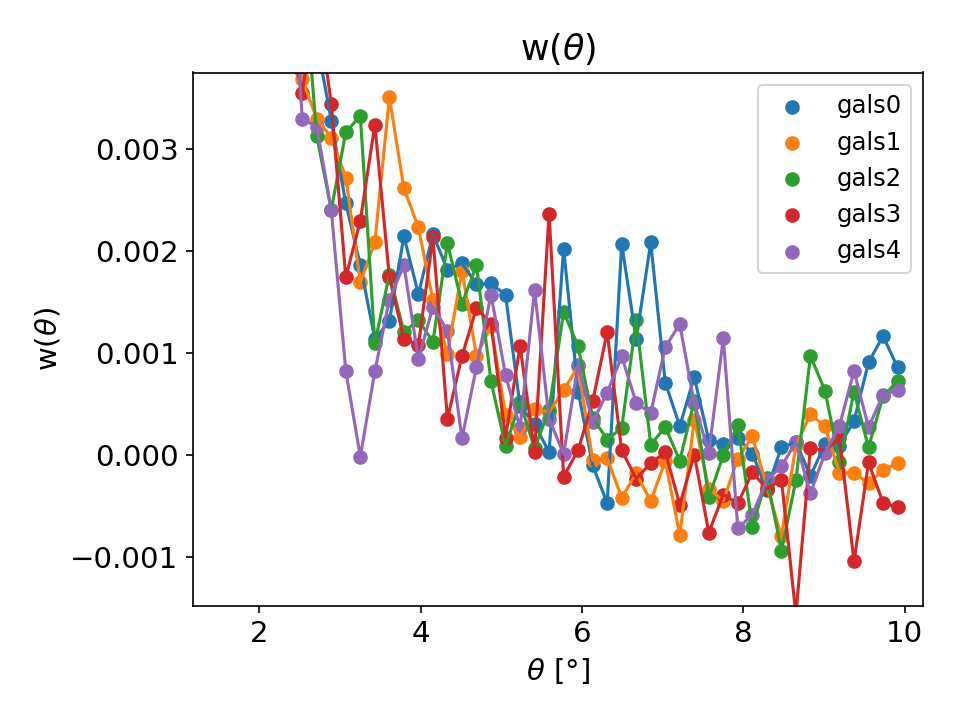

In [36]:
# PLOTS WTHETA for multiple galaxy tables

plt.figure()
for i, data in enumerate(wtheta_list):
    bcens, w_theta = data
    plt.scatter(bcens, w_theta, label='gals'+str(i))
    plt.plot(bcens, w_theta)
plt.legend()
plt.xlabel(r'$\theta$ [$\degree$]')
plt.ylabel(r'w($\theta$)')
plt.title(r'w($\theta$)')
plt.tight_layout()
plt.show()

In [ ]:
# CHECK SOME THINGS

# print(np.max(ran_rad), np.min(ran_rad))
# print(np.max(ran_decd), np.min(ran_decd))

#Nran=5
# print(np.random.random((Nran,3))*1000)
#print(np.random.random((Nran,3))*HODmodel.mock.Lbox)

#rand_RA, rand_DEC = get_randoms(Nran=5, boxsize=1000)
print(type(rand_RA[0]), type(rand_DEC[0]))
print()
print(type(RA[0]), type(DEC[0]))

# ra, dec, z = get_ra_dec_z(gals)
# print(np.max(ra), np.min(ra))
# print(np.max(dec), np.min(dec))
# print(np.max(z), np.min(z))

#nthreads = 48
#boxsize = halocat.Lbox[0]
#nbins = 10
#bins = np.linspace(0.1, 10.0, nbins + 1) # theta values [degrees] for bin-edges
#autocorr=1
#RA, DEC, __ = get_ra_dec_z(gals)
#DD_counts = DDtheta_mocks(autocorr, nthreads, bins, RA, DEC)
#DD_counts

# len(RA)

In [27]:
galslst

[<Table length=475174>
     halo_mvir     halo_vx   halo_y  ...     y         x    
      float32      float32  float32  ...  float32   float32 
 ----------------- ------- --------- ... --------- ---------
 458600000000000.0  120.86 171.52242 ... 171.52242  143.0807
  56250000000000.0 -540.69 173.41821 ... 173.41821 144.34467
   7022000000000.0  -549.1 172.09048 ... 172.09048 144.72221
 375800000000000.0  562.79 179.20776 ... 179.20776 176.48647
 488400000000000.0 -128.48  53.65187 ...  53.65187  90.55355
 105600000000000.0  743.36  55.39077 ...  55.39077  88.17712
 457700000000000.0  420.35 240.05305 ... 240.05305  40.75259
 457400000000000.0   42.83  141.1874 ...  141.1874 227.04915
 572200000000000.0   26.69  77.74155 ...  77.74155  69.46844
 394300000000000.0  116.77  43.70128 ...  43.70128 249.13126
               ...     ...       ... ...       ...       ...
   3341000000000.0  457.75 969.59827 ...  969.5966 997.35895
  35420000000000.0  641.68 994.55164 ...  994.1148   977.148
 

# Old

In [ ]:
# mask = model.mock.galaxy_table['stellar_mass'] > 10**10.5
gals = HODmodel.mock.galaxy_table
coords = np.vstack([gals['x'], gals['y'], gals['z']]).T
vels = np.vstack([gals['vx'], gals['vy'], gals['vz']]).T

In [ ]:
ra, dec, z = mock_survey.ra_dec_z(coords, vels)#, cosmo=model.mock.cosmology)
ra = np.degrees(ra)
dec = np.degrees(dec)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ra,dec,'.',color='red')
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.ylabel(r'$\delta$  $[{\rm degrees}]$', fontsize=20)
plt.xlabel(r'$\alpha$  $[{\rm degrees}]$', fontsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.title('Mock catalog in angular coordinates', fontsize=20)

In [ ]:
# using randoms:

Nran=10**5
ran_coords = np.random.random((Nran,3))*model.mock.Lbox
ran_vels = np.zeros((Nran,3))

ran_ra, ran_dec, ran_z = mock_survey.ra_dec_z(ran_coords, ran_vels)#, cosmo=model.mock.cosmology)
ran_ra = np.degrees(ran_ra)
ran_dec = np.degrees(ran_dec)

In [ ]:

angular_coords = np.vstack((ra,dec)).T
ran_angular_coords = np.vstack((ran_ra,ran_dec)).T

theta_bins = np.logspace(-2,0,15)
cen_theta_bins = (theta_bins[:-1]+theta_bins[1:])/2.0

w_theta_with_randoms = angular_tpcf(angular_coords, theta_bins, \
                                    randoms=ran_angular_coords, num_threads='max')

In [ ]:
plt.figure()
plt.plot(cen_theta_bins,1.0+w_theta_with_randoms,'o-')
plt.loglog()
plt.ylabel(r'$1+w_{\theta}$', fontsize=20)
plt.xlabel(r'$\theta$  $[{\rm degrees}]$', fontsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Angular correlation function', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
# without randoms
coords = np.vstack((gals['x'],gals['y'],gals['z'])).T - HODmodel.mock.Lbox/2.0
vels = np.vstack((gals['vx'],gals['vy'],gals['vz'])).T

ra_init, dec_init, z = mock_survey.ra_dec_z(coords, vels)#, cosmo=model.mock.cosmology)

#keep a complete spherical volume
r = np.sqrt(coords[:,0]**2 + coords[:,1]**2 + coords[:,2]**2)
# keep = r<model.mock.Lbox/2.0
keep = r<np.sqrt(np.sum(HODmodel.mock.Lbox[:]**2))/2.0

ra = np.degrees(ra_init[keep])
dec = np.degrees(dec_init[keep])

In [ ]:
plt.figure()
plt.plot(ra,dec,'.',color='blue', ms=0.01)
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.ylabel(r'$\delta$  $[{\rm degrees}]$', fontsize=20)
plt.xlabel(r'$\alpha$  $[{\rm degrees}]$', fontsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.title('Mock catalog in angular coordinates', fontsize=20)
plt.show()

In [ ]:
theta_bins = np.logspace(-2,0,150)
cen_theta_bins = (theta_bins[:-1]+theta_bins[1:])/2.0


angular_coords = np.vstack((ra,dec)).T
w_theta = angular_tpcf(angular_coords, theta_bins, num_threads='max')

In [ ]:


plt.figure()
# plt.plot(cen_theta_bins,1.0+w_theta,'o-', label='analytic randoms')
plt.plot(cen_theta_bins,w_theta,'o-', label='analytic randoms')
# plt.plot(cen_theta_bins,1.0+w_theta_with_randoms,'o-', label = 'manual randoms')
plt.loglog()
plt.ylabel(r'$w_{\theta}$', fontsize=20)
plt.xlabel(r'$\theta$  $[{\rm degrees}]$', fontsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Angular correlation function', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.tight_layout()
plt.show()

# Older

In [ ]:
rr, xi_cc, xi_cs, xi_ss = zheng07_model.compute_average_galaxy_clustering(\
                            gal_type = 'centrals', include_crosscorr = True, \
                            num_iterations = 3, num_threads = 'max') 

In [ ]:
# https://halotools.readthedocs.io/en/latest/api/halotools.empirical_models.ModelFactory.html#halotools.empirical_models.ModelFactory.compute_average_galaxy_clustering
# "The compute_average_galaxy_clustering is simply a convenience function, and is not intended for use in performance-critical applications such as MCMCs"

rbins = np.linspace(45,200, num=50)

r, xi_gg = HODmodel.compute_average_galaxy_clustering(rbins=rbins, simname='multidark')

In [ ]:
# Plot 3D correlation function

plt.figure()
plt.scatter(r,xi_gg)
# plt.loglog()
plt.axis([45,200, -0.001,0.004])
plt.xlabel(r'$r $  $\rm{[Mpc/h]}$')
plt.ylabel('xi_gg')
plt.show()

In [ ]:
rp_bins = np.logspace(-1,1.25,15)
from halotools.mock_observables import wp


In [ ]:
# 2D correlation funciton, w_p
# following- https://halotools.readthedocs.io/en/latest/quickstart_and_tutorials/tutorials/catalog_analysis/galcat_analysis/basic_examples/clustering_examples/galaxy_catalog_analysis_tutorial4.html#galaxy-catalog-analysis-tutorial4
# and- https://halotools.readthedocs.io/en/latest/api/halotools.mock_observables.wp.html#halotools.mock_observables.wp
x = gals['x']
y = gals['y']
z = gals['z']
pos = return_xyz_formatted_array(x, y, z)


pi_max = 125.

w_p = wp(pos, bins, pi_max, period=HODmodel.mock.Lbox, num_threads='max')

In [ ]:
# Plot w_p
bin_centers = (bins[:-1] + bins[1:])/2.

plt.figure()
plt.plot(bin_centers, w_p)
# plt.axis([45,200, -0.2,1.])
plt.xlabel(r'$r $  $\rm{[Mpc/h]}$')
plt.ylabel('w_p')
plt.show()

In [ ]:
rp_bin_centers = (rbins[:-1] + rbins[1:])/2.
rbins[:-1]

In [ ]:
rp_bin_centers

In [ ]:
?zheng07_model.compute_average_galaxy_clustering

In [ ]:
?PrebuiltHodModelFactory